# Particle-Field interaction

This notebook illustrates a simple way to make particles interact with a ` Field` object and modify it. The ` Field` will thus change at each step of the simulation, and will be written using the same time resolution as the particle outputs, in as many `netCDF` files.

The concept is similar to that of [Field sampling](https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html): here instead, on top of reading the field value at their location, particles are able to alter it as defined in the `Kernel`. To do this, it is important to keep in mind that:

- Particles have to be defined as `ScipyParticles`
- `Field` writing at each `outputdt` is not default and has to be enabled
- The time of the `Field` to be saved has to be updated within a `Kernel`

In this example, particles will carry a tracer and release it into a clean `Field` during their advection by surface currents. To show how can particles interact with a `Field` and alter it, the exchange of such tracer is modelled here with a discretized version of the mass transfer equation, defined as follows:

\begin{equation}
\Delta c*{particle}(t) = aC*{field}(t-1) - bc\_{particle}(t-1)
\end{equation}

In Eq.1, $c_{particle}$ is the tracer concentration associated with the particle, $C_{field}$ is the tracer concentration in seawater at particle location, and $a$ and $b$ are weights that modulate the sorption of tracer from seawater and its desorption, respectively.

Additionally to a relevant `Kernel`, we will define a suitable particle class to store $c_{particle}$, as it is needed to solve Eq.1.


## Particle altering a Field during advection


In [1]:
%matplotlib inline
from datetime import timedelta as delta

import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import xarray as xr

from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    ParticleSet,
    ScipyParticle,
    Variable,
    download_example_dataset,
)

In this specific example, particles will be advected by surface ocean velocities stored in netCDF files in the folder `GlobCurrent_example_data`. We will store these in a `FieldSet` object, and then add a `Field` to it to represent the tracer field. This latter field will be initialized with zeroes, as we assume that this tracer is absent on the ocean surface and released by particles only. Note that, in order to conserve mass, it is important to set `interp_method='nearest'` for the tracer Field.

As we are interested in storing this new field during the simulation, we will set its `.to_write` method to `True`. Note that this only works for Fields that consist of only _one_ snapshot in time.


In [2]:
# Velocity fields
example_dataset_folder = download_example_dataset("GlobCurrent_example_data")
fname = f"{example_dataset_folder}/*.nc"
filenames = {"U": fname, "V": fname}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {
    "U": {"lat": "lat", "lon": "lon", "time": "time"},
    "V": {"lat": "lat", "lon": "lon", "time": "time"},
}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

# In order to assign the same grid to the tracer field,
# it is convenient to load a single velocity file
fname1 = f"{example_dataset_folder}/20030101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc"
filenames1 = {"U": fname1, "V": fname1}

# a field with the same variables and dimensions
# as the other velocity fields
field_for_size = FieldSet.from_netcdf(filenames1, variables, dimensions)

# Adding the tracer field to the FieldSet
# with same dimensions as the velocity fields
dimsC = [len(field_for_size.U.lat), len(field_for_size.U.lon)]
dataC = np.zeros([dimsC[0], dimsC[1]])

# the new Field will be called C, for tracer Concentration.
# For mass conservation, interp_method='nearest'
fieldC = Field("C", dataC, grid=field_for_size.U.grid, interp_method="nearest")

# aad C field to the velocity FieldSet
fieldset.add_field(fieldC)

# enable the writing of Field C during execution
fieldset.C.to_write = True

Some global parameters have to be defined, such as $a$ and $b$ of Eq.1, and a weight that works as a conversion factor from $\Delta c_{particle}$ to $C_{field}$.
We will add these parameters to the `FieldSet`.


In [3]:
fieldset.add_constant("a", 10)
fieldset.add_constant("b", 0.2)
fieldset.add_constant("weight", 0.01)

We will now define a new particle class. A `VectorParticle` is a `ScipyParticle` having a `Variable` to store the current tracer concentration `c` associated with it. As in this case we want our particles to release a tracer into a clean field, we will initialize `c` with an arbitrary value of `100`.

We also need to define the `Kernel` that performs the particle-field interaction. In this Kernel, we will implement Eq.1, so that $\Delta c_{particle}$ can be used to update $c_{particle}$ and $C_{field}$ at the particle location, and thus get their values at the current time $t$.

Additionally, the time of `fieldset.C` is updated within the `Interaction` Kernel, which is an important step to properly write its value.


In [4]:
class VectorParticle(ScipyParticle):
    """initialise particle concentration c with a non-zero value"""

    c = Variable("c", dtype=np.float32, initial=100.0)


def Interaction(particle, fieldset, time):
    """define the interaction between the particle and the fieldset.C field.
    the exchange is obtained as a discretized mass transfer equation,
    with a and b as the rate constants"""
    deltaC = fieldset.a * fieldset.C[particle] - fieldset.b * particle.c

    xi, yi = (
        particle.xi[fieldset.C.igrid],
        particle.yi[fieldset.C.igrid],
    )
    if abs(particle.lon - fieldset.C.grid.lon[xi + 1]) < abs(
        particle.lon - fieldset.C.grid.lon[xi]
    ):
        xi += 1
    if abs(particle.lat - fieldset.C.grid.lat[yi + 1]) < abs(
        particle.lat - fieldset.C.grid.lat[yi]
    ):
        yi += 1

    particle.c += deltaC

    # weight, defined as a constant for the FieldSet, acts here as a conversion factor between c_particle and C_field
    fieldset.C.data[0, yi, xi] += -deltaC * fieldset.weight

    # update Field C time
    fieldset.C.grid.time[0] = time


def WriteInitial(particle, fieldset, time):
    """store the initial conditions of fieldset.C"""
    fieldset.C.grid.time[0] = time


# for simplicity, we'll track a single particle here
pset = ParticleSet(fieldset=fieldset, pclass=VectorParticle, lon=[24.5], lat=[-34.8])

Three things are worth noticing in the code above:

- The use of `fieldset.C[particle]`
- The computation of the relevant grid cell (`xi`, `yi`)
- Writing $C_{field}$ through `fieldset.C.data[0, yi, xi]`

Because `fieldset.C[particle]` interpolates the $C_{field}$ value from the nearest grid cell to the particle, it is important to also write to that same grid cell. That is not completely trivial to do in Parcels, which is why lines 7-11 in the cell above calculate which `xi` and `yi` are closest to the particle longitude and latitude (this extends trivially to depth too). Our first guess is `particle.xi[fieldset.C.igrid]`, the location in the particular grid, but it could be that `xi+1` is closer, which is what the `if`-statements are for.

The new indices are then used in `fieldset.C.data[0, yi, xi]` to access the field value in the cell where the particle is found, that can be different from the result of the interpolation at the particle's coordinates. Note that here we need to use `fieldset.C.data[0, yi, xi]` both for calculating `deltaC` and for the consequent update of the cell value for consistency between the forcing (the seawater-particle gradient) and its effect (the exchange, and consequent alteration of the field).

Remember that reading and writing `Fields` at particle location through particle indices is only possible for `ScipyParticles` (and returns an error if `JITParticles` are used).


Now we are going to execute the advection of the particle and the simultaneous release of the tracer it carries. We will thus add the `interactionKernel` defined above to the built-in Kernel `AdvectionRK4`.

Before running the advection, we will execute the `pset` with the `WriteInitial` for `dt=0`: this will write the initial condition of fieldset.C to a `netCDF` file.

While particle outputs will be written in a file named `interaction.zarr` at every `outputdt`, the field will be automatically written in `netCDF` files named `interaction_wxyzC.nc`, with `wxyz` being the number of the output and `C` the `FieldSet` variable of our interest. Note that you can use tools like [ncrcat](https://linux.die.net/man/1/ncrcat) (on linux/macOS) to combine these separate files into one large `netCDF` file after the simulation.


In [5]:
output_file = pset.ParticleFile(name=r"interaction.zarr", outputdt=delta(days=1))

pset.execute(WriteInitial, dt=0.0, output_file=output_file)

pset.execute(
    # the particle will FIRST be transported by currents
    # and THEN interact with the field
    AdvectionRK4 + pset.Kernel(Interaction),
    dt=delta(days=1),
    # we are going to track the particle and save
    # its trajectory and tracer concentration for 24 days
    runtime=delta(days=24),
    output_file=output_file,
)

We can see that $c_{particle}$ has been saved along with particle trajectory, as expected.


[[100.          80.          64.          51.2         40.96
   32.767998    26.214397    20.971518    16.777214    13.421771
   11.072961     9.428794     7.9624653    6.369972     5.095978
    4.076782     3.3633454    2.6906762    2.152541     1.7758462
    1.420677     1.1720585    0.93764675   0.7501174    0.6235351 ]]


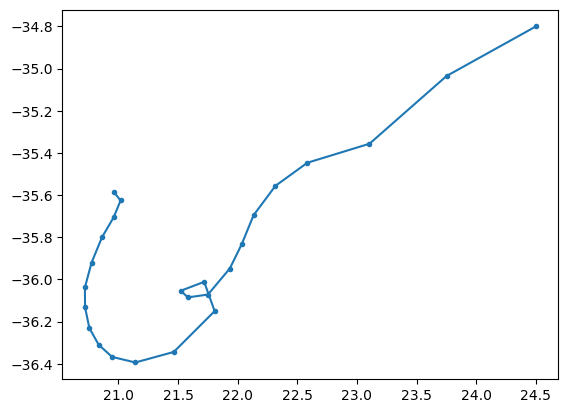

In [6]:
pset_traj = xr.open_zarr(r"interaction.zarr")

print(pset_traj["c"].values)

plt.plot(pset_traj["lon"].T, pset_traj["lat"].T, '.-')

But what about `fieldset.C`? We can see that it has been accordingly modified during particle motion. Using `fieldset.C` we can access the field as resulting at the end of the run, with no information about the previous time steps.


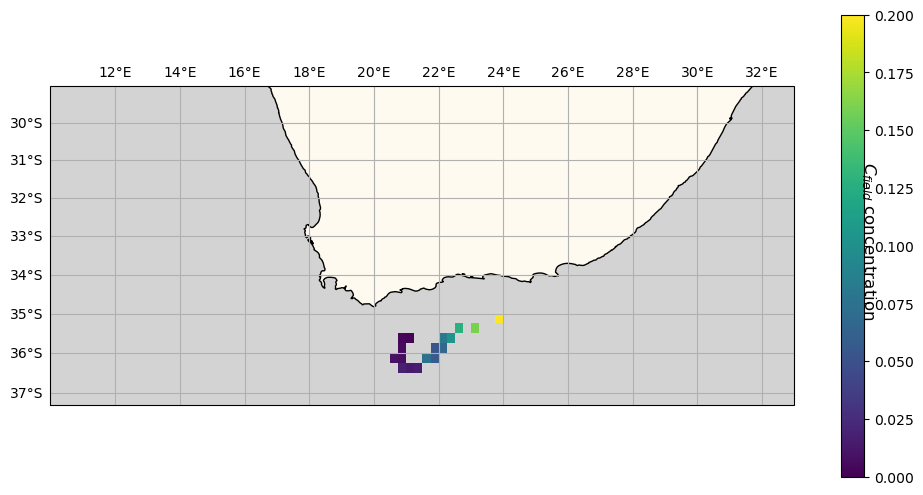

In [7]:
# Copy the final field data in a new array
c_results = fieldset.C.data[0, :, :].copy()

# using a mask for fieldset.C.data on land
c_results[[field_for_size.U.data == 0][0][0]] = np.nan

# masking the field where its value is zero:
# areas that have not been modified by the particle,
# for clearer plotting
c_results[c_results == 0] = np.nan

try:  # Works if Cartopy is installed
    import cartopy
    import cartopy.crs as ccrs

    extent = [10, 33, -37, -29]

    X = fieldset.U.lon
    Y = fieldset.U.lat

    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN, facecolor="lightgrey")
    ax.add_feature(cartopy.feature.LAND, edgecolor="black", facecolor="floralwhite")
    gl = ax.gridlines(
        xlocs=np.linspace(10, 34, 13), ylocs=np.linspace(-29, -37, 9), draw_labels=True
    )
    gl.right_labels = False
    gl.bottom_labels = False

    xx, yy = np.meshgrid(X, Y)

    results = ax.pcolormesh(
        xx,
        yy,
        (c_results),
        transform=ccrs.PlateCarree(),
        vmin=0,
    )
    cbar = plt.colorbar(mappable=results, ax=ax)
    cbar.ax.text(0.8, 0.070, "$C_{field}$ concentration", rotation=270, fontsize=12)

except:
    print("Please install the Cartopy package.")

When looking at tracer concentrations, we see that $c_{particle}$ decreases along its trajectory (right to left), as it is releasing the tracer it carries. Accordingly, values of $C_{field}$ provided by particle interaction progressively reduce along the particle's route.

Notice that the first particle-field interaction occurs at time $t = 1$ day, and namely after the execution of the first step of `AdvectionRK4`, as shown by the unaltered field value at the particle's starting location.
In order to let the particle interact before being advected, we would have to change the order in which the two Kernels are added together in `pset.execute`, i.e. `pset.execute(interactionKernel + AdvectionRK4, ...)`. In this latter case, the interaction would not occur at the particle's final position instead.


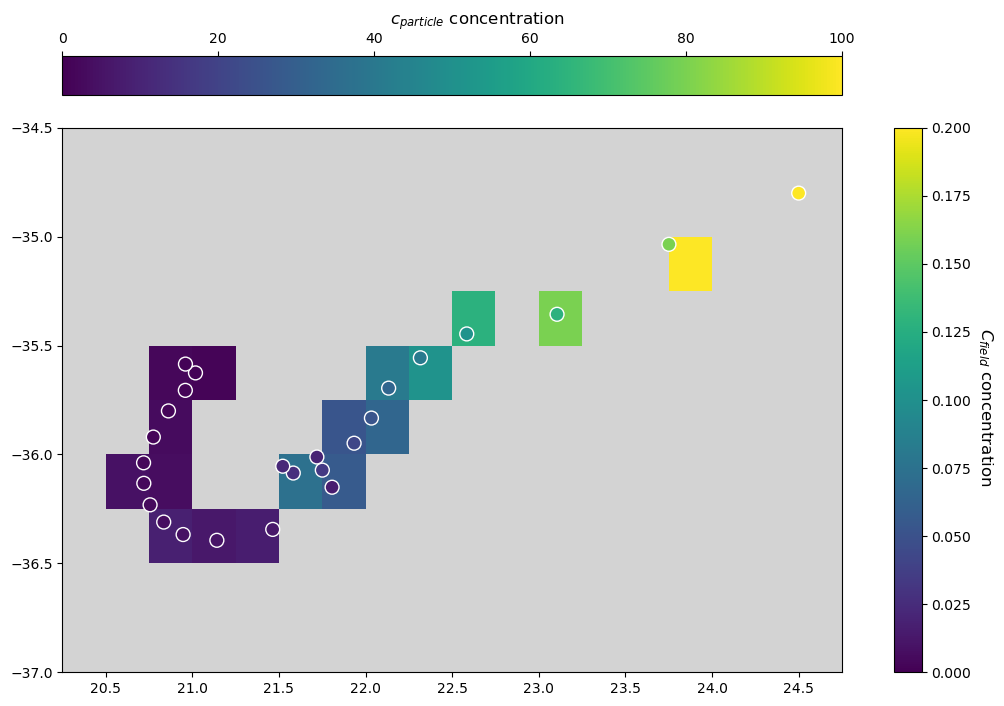

In [8]:
x_centers, y_centers = np.meshgrid(
    fieldset.U.lon - np.diff(fieldset.U.lon[:2]) / 2,
    fieldset.U.lat - np.diff(fieldset.U.lat[:2]) / 2,
)

fig, ax = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)
ax.set_facecolor("lightgrey")  # For visual coherence with the plot above

fieldplot = ax.pcolormesh(
    x_centers[-28:-17, 22:41],
    y_centers[-28:-17, 22:41],
    c_results[-28:-18, 22:40],
    vmin=0,
    vmax=0.2,
    cmap="viridis",
)
# Zoom on the area of interest
field_cbar = plt.colorbar(fieldplot, ax=ax)
field_cbar.ax.text(3, 0.070, "$C_{field}$ concentration", rotation=270, fontsize=12)

particle = plt.scatter(
    pset_traj["lon"][:].values[0, :],
    pset_traj["lat"][:].values[0, :],
    c=pset_traj["c"][:].values[0, :],
    vmin=0,
    s=100,
    edgecolor="white",
)
particle_cbar = plt.colorbar(particle, ax=ax, location="top")
particle_cbar.ax.text(42, 1.8, "$c_{particle}$ concentration", fontsize=12);

Finally, to see the `C` field in time we have to load the `.nc` files produced during the run. In the following plots, particle location and field values are shown at each time step.


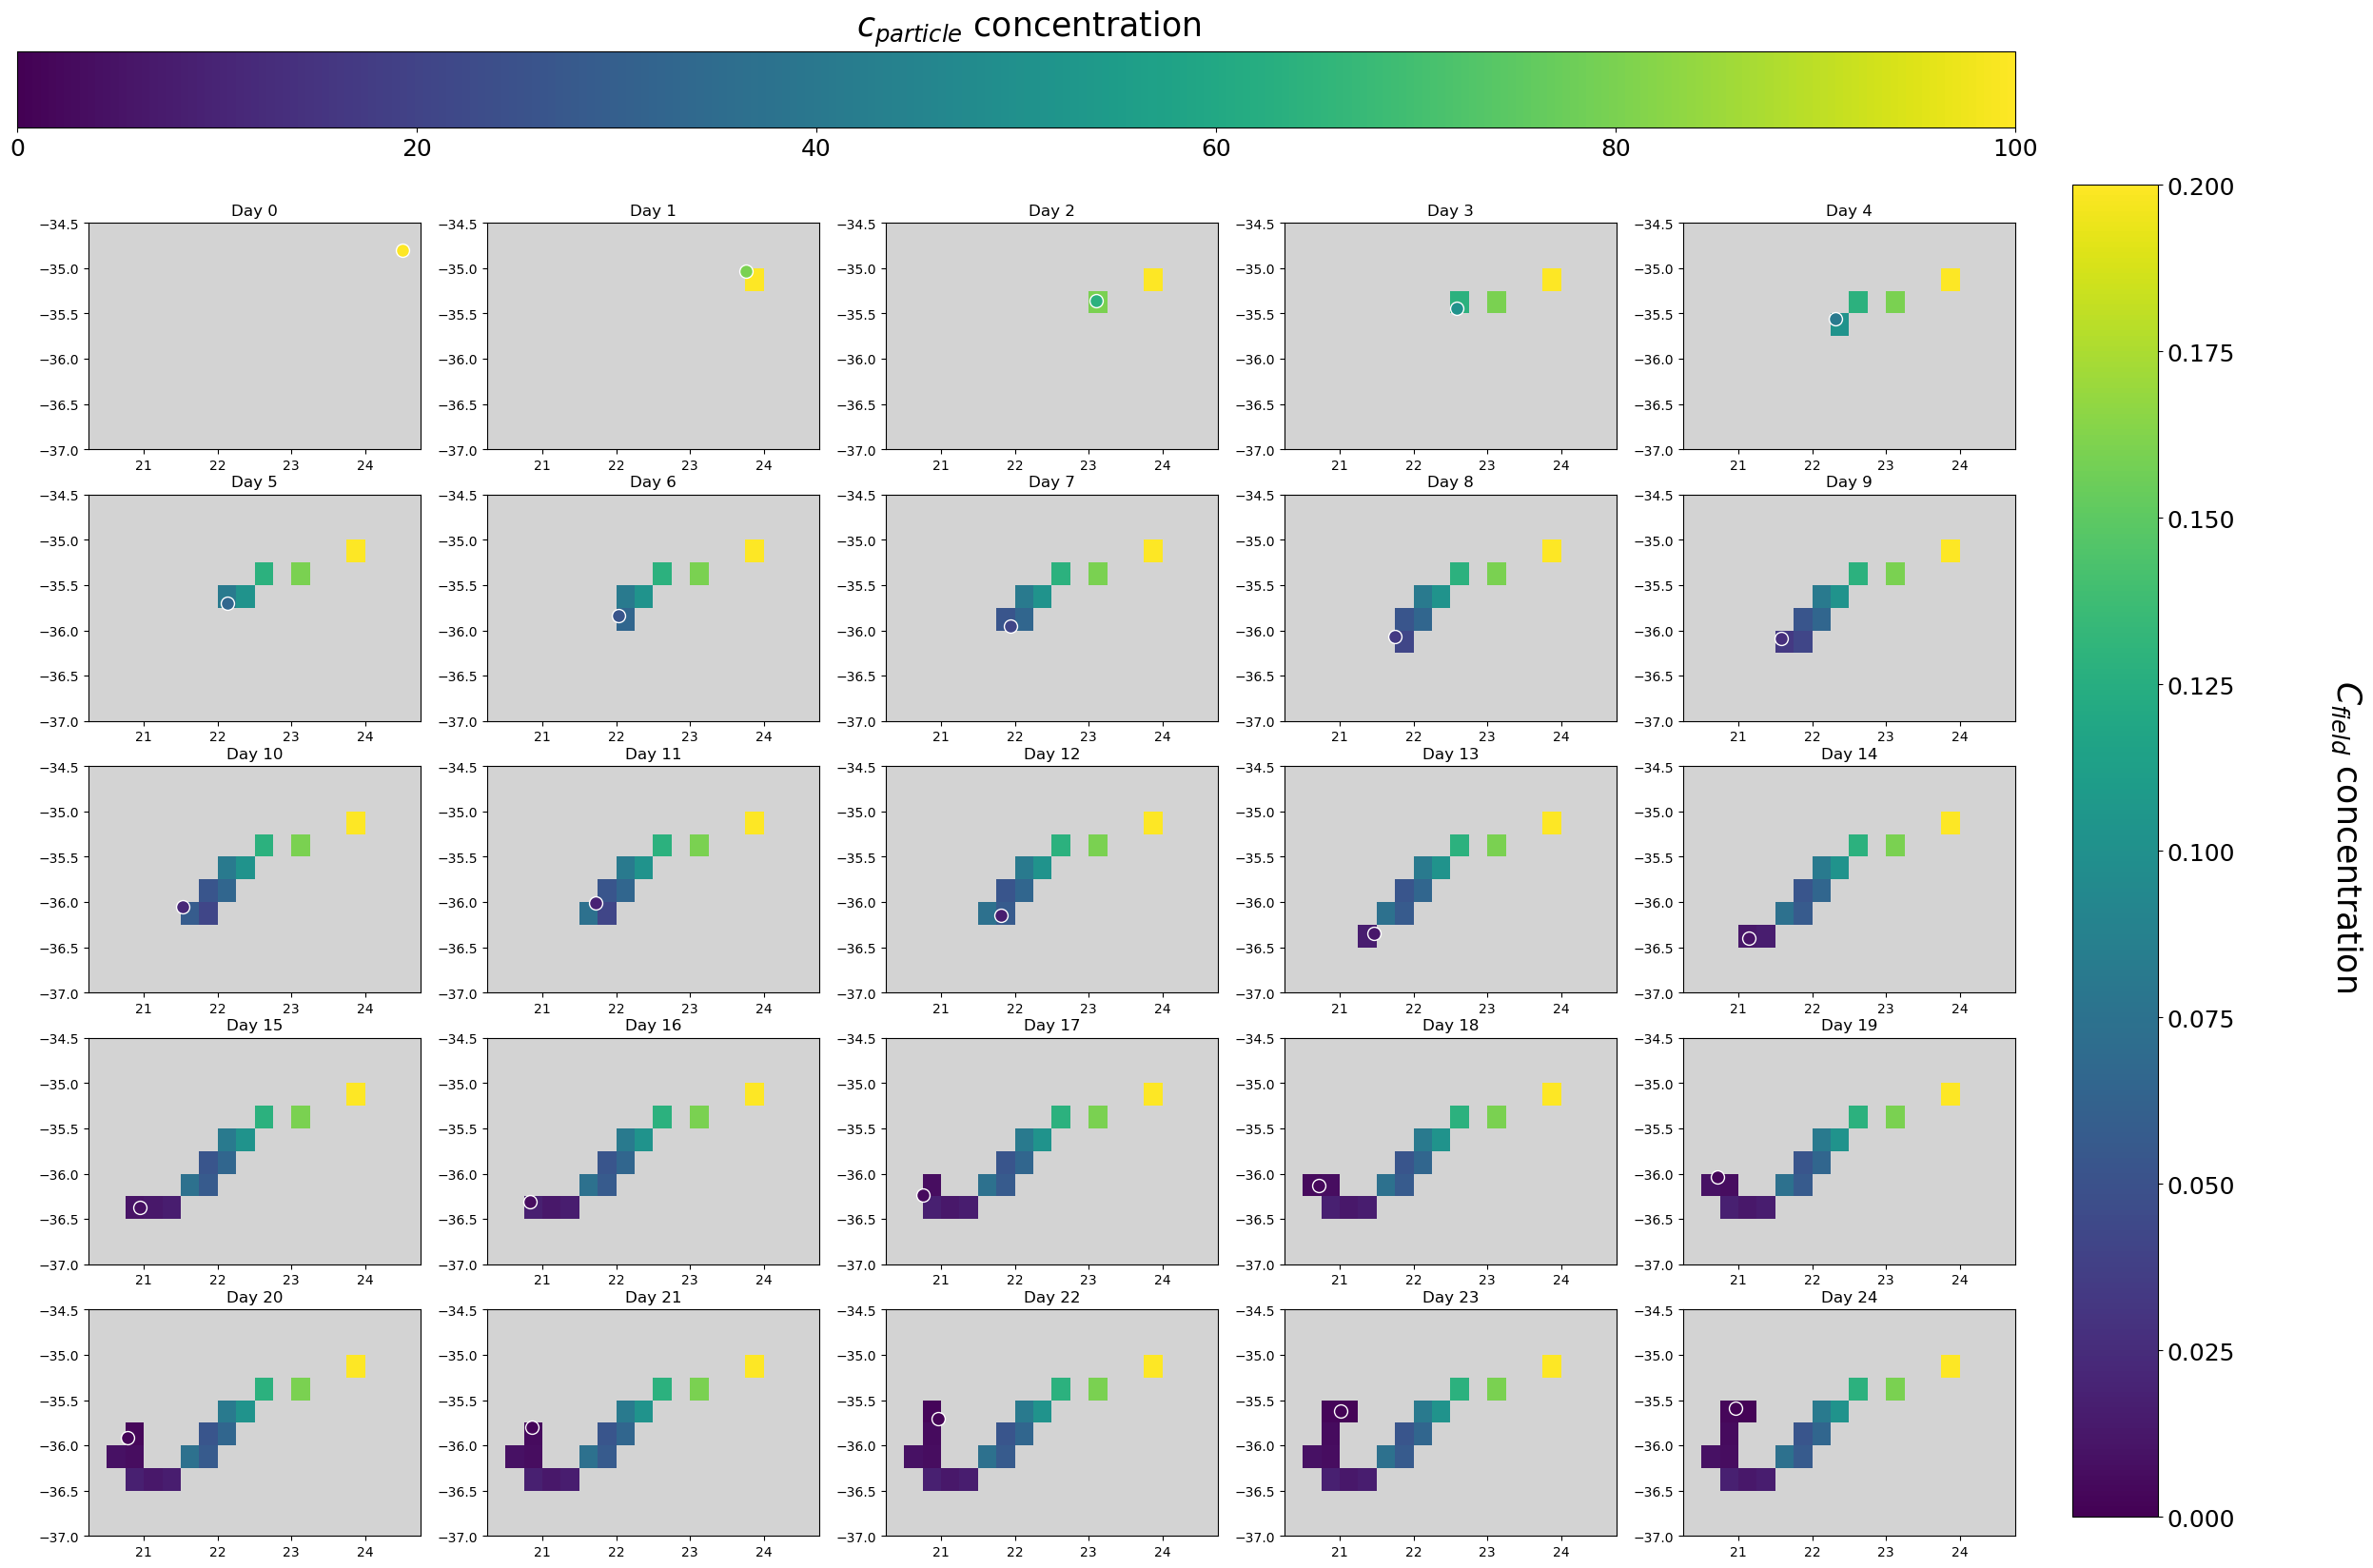

In [9]:
fig, ax = plt.subplots(5, 5, figsize=(30, 20))

daycounter = 1

for i in range(len(ax)):
    for j in range(len(ax)):
        data = netCDF4.Dataset(r"interaction_00" + f"{daycounter:02}" + "C.nc")

        # copying the final field data in a new array
        c_results = data["C"][0, 0, :, :].data.copy()

        # using a mask for fieldset.C.data on land
        c_results[[field_for_size.U.data == 0][0][0]] = np.nan

        # masking the field where its value is zero:
        # areas that have not been modified by the particle,
        # for clearer plotting
        c_results[c_results == 0] = np.nan

        # visual coherence with the plots above
        ax[i, j].set_facecolor("lightgrey")

        fieldplot = ax[i, j].pcolormesh(
            x_centers[-28:-17, 22:41],
            y_centers[-28:-17, 22:41],
            c_results[-28:-18, 22:40],
            vmin=0,
            vmax=0.2,
            cmap="viridis",
        )

        particle = ax[i, j].scatter(
            pset_traj["lon"][:].values[0, daycounter - 1],
            pset_traj["lat"][:].values[0, daycounter - 1],
            c=pset_traj["c"][:].values[0, daycounter - 1],
            vmin=0,
            vmax=100,
            s=100,
            edgecolor="white",
        )

        # plotting particle location at current time step:
        # daycounter-1 due to different indexing
        ax[i, j].set_title("Day " + str(daycounter - 1))

        daycounter += 1  # next day

fig.subplots_adjust(right=0.8)
fig.subplots_adjust(top=0.8)

cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.7])
fig.colorbar(fieldplot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=18)
cbar_ax.text(3, 0.08, "$C_{field}$ concentration", fontsize=25, rotation=270)

cbar_ax1 = fig.add_axes([0.1, 0.85, 0.7, 0.04])
fig.colorbar(particle, cax=cbar_ax1, orientation="horizontal")
cbar_ax1.tick_params(labelsize=18)
cbar_ax1.text(42, 1.2, "$c_{particle}$ concentration", fontsize=25);